In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf

# 야후에서 데이터를 획득하는 방식이 크롤링으로 변경되어 주가 데이터를 불러옵니다.
yf.pdr_override()

In [16]:
now = datetime.now()
before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
before_day = before.strftime("%Y-%m-%d")
print(f'end:{now_day}')
print(f'start:{before_day}')

samsung_stock = pdr.get_data_yahoo("005930.KS", start=before_day, end=now_day)
print(samsung_stock)

end:2023-11-10
start:2013-11-10
[*********************100%%**********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2013-11-11  28500.0  28680.0  28180.0  28560.0  22590.837891   8563850
2013-11-12  28800.0  29320.0  28720.0  29120.0  23033.789062   9784900
2013-11-13  28900.0  28980.0  28380.0  28380.0  22448.457031   9995200
2013-11-14  29100.0  29100.0  28480.0  28480.0  22527.556641  10132150
2013-11-15  28680.0  29240.0  28640.0  29240.0  23128.714844   8339250
...             ...      ...      ...      ...           ...       ...
2023-11-03  69700.0  70200.0  69500.0  69600.0  69600.000000  10322234
2023-11-06  69800.0  70900.0  69300.0  70900.0  70900.000000  22228489
2023-11-07  70600.0  70900.0  70000.0  70900.0  70900.000000  17228731
2023-11-08  71300.0  71400.0  69700.0  69900.0  69900.000000  12901310
2023-11-09  69900.0  70800.0  69600.0  70300.0 

In [17]:
close_prices = samsung_stock['Close'].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices) - (windown_size + 1)):
    result_list.append(close_prices[i: i+(windown_size+1)])

normal_data = []
for window in result_list:
    window_list = [((float(p) / float(window[0])) - 1) for p in window]
    normal_data.append(window_list)
    
result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[28560. 29120. 28380. ... 70900. 69900. 70300.]
2426 31


In [18]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]

x_test = result_list[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))
y_test = result_list[row:,-1]

x_train.shape, x_test.shape

((2183, 30, 1), (243, 30, 1))

In [20]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(x_train, y_train,
          validation_data=(x_test,y_test),
          batch_size=10,
          epochs=10)

model.save(r'C:\vscode\ToyProjects\39. 주식\samsung.h5')


Epoch 1/10
  1/219 [..............................] - ETA: 0s - loss: 3.1536e-04

219/219 [==============================] - 3s 12ms/step - loss: 3.0712e-04 - val_loss: 2.8583e-04
Epoch 2/10
219/219 [==============================] - 3s 12ms/step - loss: 3.0472e-04 - val_loss: 2.1254e-04
Epoch 3/10
219/219 [==============================] - 3s 12ms/step - loss: 3.0252e-04 - val_loss: 2.4063e-04
Epoch 4/10
219/219 [==============================] - 3s 14ms/step - loss: 3.0188e-04 - val_loss: 2.0029e-04
Epoch 5/10
219/219 [==============================] - 3s 14ms/step - loss: 3.0297e-04 - val_loss: 2.8828e-04
Epoch 6/10
219/219 [==============================] - 3s 15ms/step - loss: 2.9901e-04 - val_loss: 5.1527e-04
Epoch 7/10
219/219 [==============================] - 3s 13ms/step - loss: 3.0404e-04 - val_loss: 2.6632e-04
Epoch 8/10
219/219 [==============================] - 3s 11ms/step - loss: 2.9782e-04 - val_loss: 2.2082e-04
Epoch 9/10
219/219 [==============================] - 3s 13ms/step - loss: 2.9644e-04 - val_loss: 2.2610e-04
Epoch 10/10
219/219 [=========

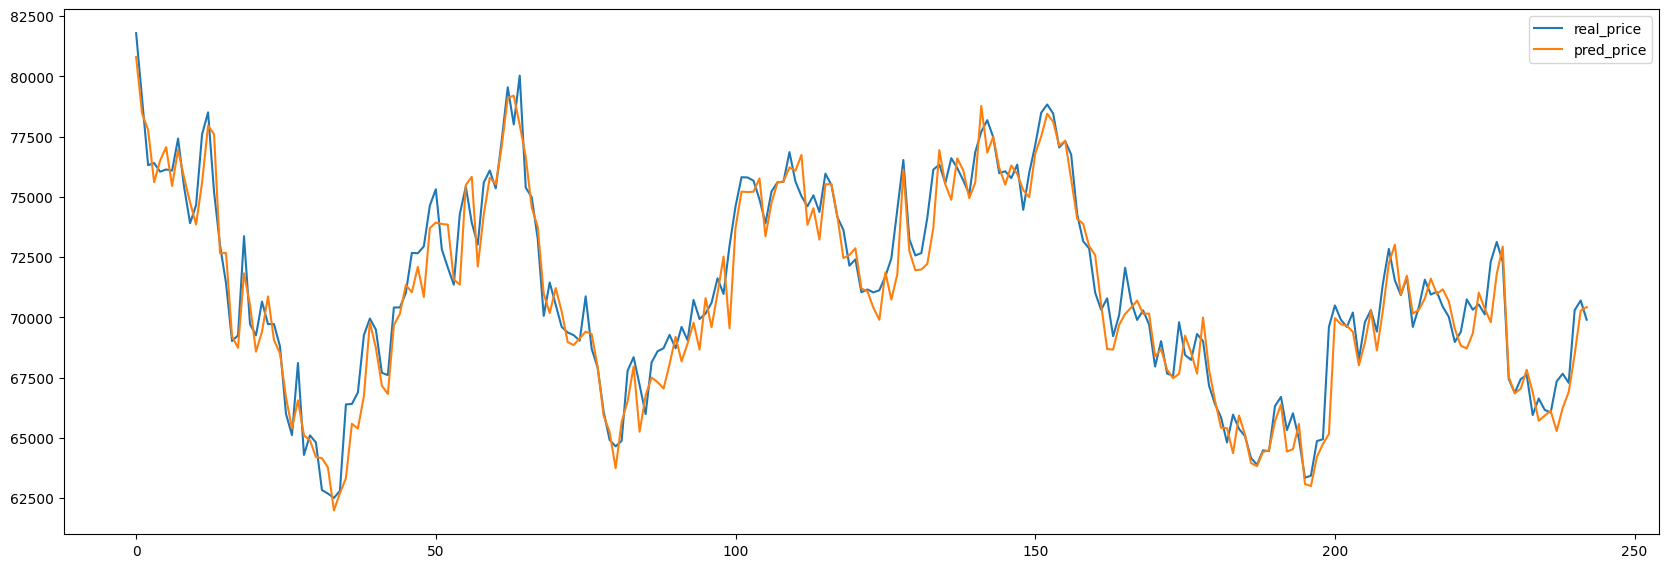

In [24]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
    pred_price.append((i+1)*window[0])
    
real_price = []
for i in y_test:
    real_price.append((i+1) * window[0])
    
fig = plt.figure(facecolor='white', figsize=(70,15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()